In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import scipy.stats as stats

In [174]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_info_columns', 10_000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200_000)     # zeigt Zeileninfo, wenn nötig


# Pfad zur Datei (liegt im gleichen Ordner wie das Notebook)
path = Path("dataset/311_Service_Requests_2024.csv")

# Einfacher Import
df = pd.read_csv(path)


In [175]:
df['CREATED_DATE'] = pd.to_datetime(df['CREATED_DATE'], errors='coerce')
df['CLOSED_DATE'] = pd.to_datetime(df['CLOSED_DATE'], errors='coerce')

In [176]:
# Anzahl Einträge von Jahr 2024
year_counts = df['CREATED_DATE'].dt.year.value_counts().sort_index()
print(year_counts.loc[2024], "Einträge im Jahr 2024")

1913929 Einträge im Jahr 2024


Bearbeitungszeit Analyse

In [177]:
# In Tagen
df["response_time"] = (df["CLOSED_DATE"] - df["CREATED_DATE"]).dt.total_seconds() / (60 * 60 * 24)

# In Stunden
df["response_time_hours"] = df["response_time"] * 24

min_days = round(df["response_time"].min(), 2)
max_days = round(df["response_time"].max(), 2)

min_hours = round(df["response_time_hours"].min(), 2)
max_hours = round(df["response_time_hours"].max(), 2)

print(f"Kürzeste Bearbeitungszeit: {min_days} Tage  ({min_hours} Stunden)")
print(f"Längste Bearbeitungszeit:  {max_days} Tage  ({max_hours} Stunden)")

Kürzeste Bearbeitungszeit: 0.0 Tage  (0.0 Stunden)
Längste Bearbeitungszeit:  638.82 Tage  (15331.56 Stunden)


In [178]:
# Bearbeitungszeit gegliedert nach Status der Aufträge
df["STATUS"] = df["STATUS"].str.lower()

erledigt = df[df["STATUS"] == "completed"].copy()
offen = df[df["STATUS"] == "open"].copy()
abgebrochen = df[df["STATUS"] == "canceled"].copy()

# Übersicht zu Status
overview = pd.DataFrame({
    "Status": ["Erledigt", "Offen", "Abgebrochen"],
    "Anzahl": [len(erledigt), len(offen), len(abgebrochen)],
})

print("\nÜbersicht der Bearbeitungszeiten:")
print(overview)



Übersicht der Bearbeitungszeiten:
        Status   Anzahl
0     Erledigt  1832119
1        Offen    42387
2  Abgebrochen    39423


Verteilung der Bearbeitungszeiten (Histrogramm, ECDF, Boxplot)

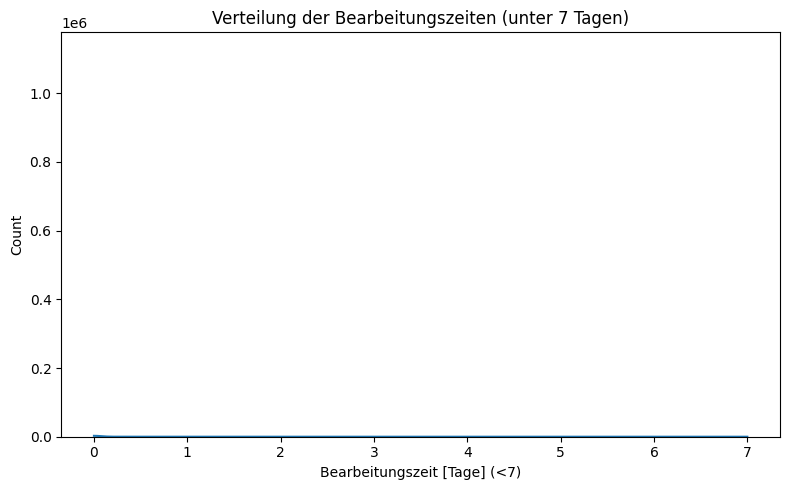

In [179]:
subset = erledigt[erledigt["response_time"] < 7]  # unter 7 Tage

plt.figure(figsize=(8,5))
sns.histplot(subset["response_time"], bins="fd", kde=True)
plt.xlabel("Bearbeitungszeit [Tage] (<7)")
plt.title("Verteilung der Bearbeitungszeiten (unter 7 Tagen)")
plt.tight_layout()
plt.show()

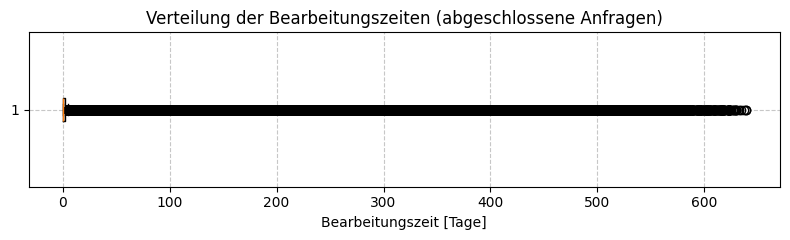

In [180]:
plt.figure(figsize=(8,2.5))
plt.boxplot(erledigt["response_time"].dropna(), vert=False)
plt.title("Verteilung der Bearbeitungszeiten (abgeschlossene Anfragen)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

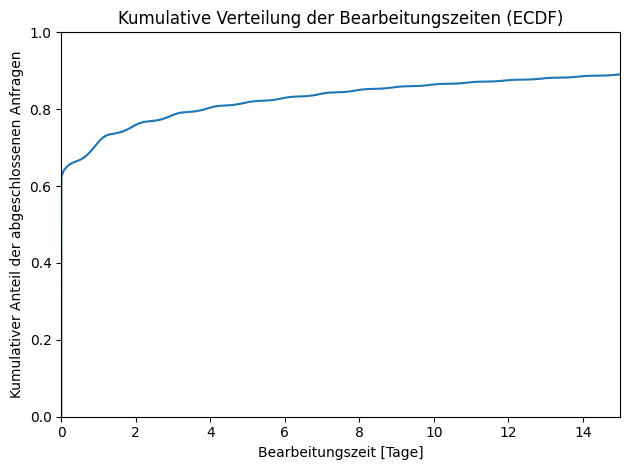

In [181]:
sns.ecdfplot(data=erledigt, x="response_time")
plt.xlim(0, 15)
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Kumulativer Anteil der abgeschlossenen Anfragen")
plt.title("Kumulative Verteilung der Bearbeitungszeiten (ECDF)")
plt.tight_layout()
plt.show()

Robuste Verteilungsdiagnostik

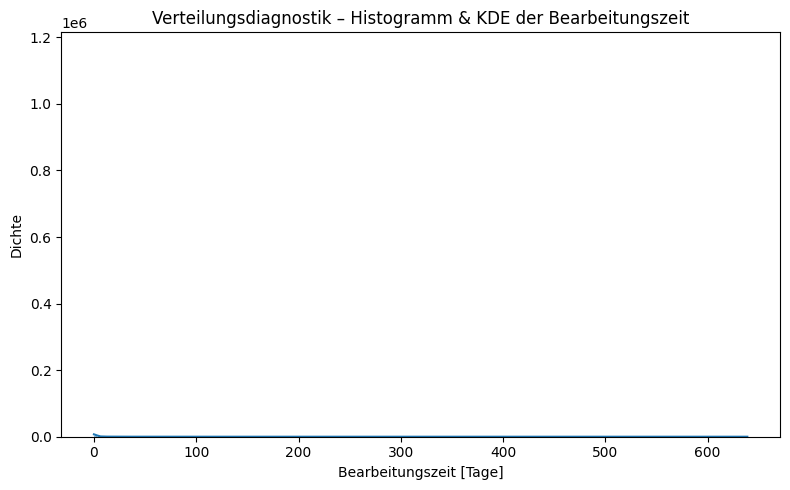

In [182]:
# Histogramm + KDE (zur visuellen Form)
plt.figure(figsize=(8,5))
sns.histplot(erledigt["response_time"], bins="fd", kde=True)
plt.title("Verteilungsdiagnostik – Histogramm & KDE der Bearbeitungszeit")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Dichte")
plt.tight_layout()
plt.show()

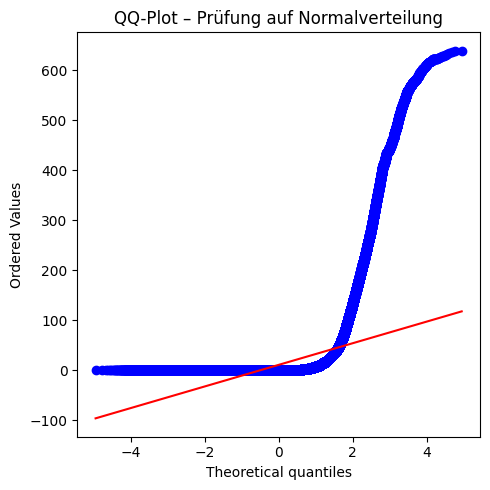

In [183]:
# QQ-Plot zur Normalitätsprüfung
plt.figure(figsize=(5,5))
stats.probplot(erledigt["response_time"].dropna(), dist="norm", plot=plt)
plt.title("QQ-Plot – Prüfung auf Normalverteilung")
plt.tight_layout()
plt.show()

Interpretation des QQ-Plots

Die blaue Kurve verläuft stark nach oben rechts und unten flach. Das bedeutet, die Verteilung der response_time weicht stark von der Normalverteilung ab.

Außerdem liegen die Punkte im mittleren Bereich kurz auf der roten Linie, danach steigen sie abrupt an. Die Verteilung ist dementsprechend stark rechtsschief, das heißt also, es gibt viele kleine Werte (kurze Bearbeitungszeiten) und einige sehr große Ausreißer mit extrem langen Bearbeitungszeiten.

In [184]:
# Schiefe
skewness = erledigt["response_time"].skew()
print(f"Schiefe (Skewness): {skewness:.2f}")

# Interpretation
if skewness > 1:
    print("Stark rechtsschief: Median ist robuster als Mittelwert.")
elif skewness > 0.5:
    print("Mäßig rechtsschief: leichte Verzerrung, Median bevorzugen.")
elif skewness < -0.5:
    print("Linksschief: Daten eher links verzerrt.")
else:
    print("Symmetrische Verteilung: Mittelwert repräsentativ.")

Schiefe (Skewness): 6.83
Stark rechtsschief: Median ist robuster als Mittelwert.


Korrelation und Zusammenhang

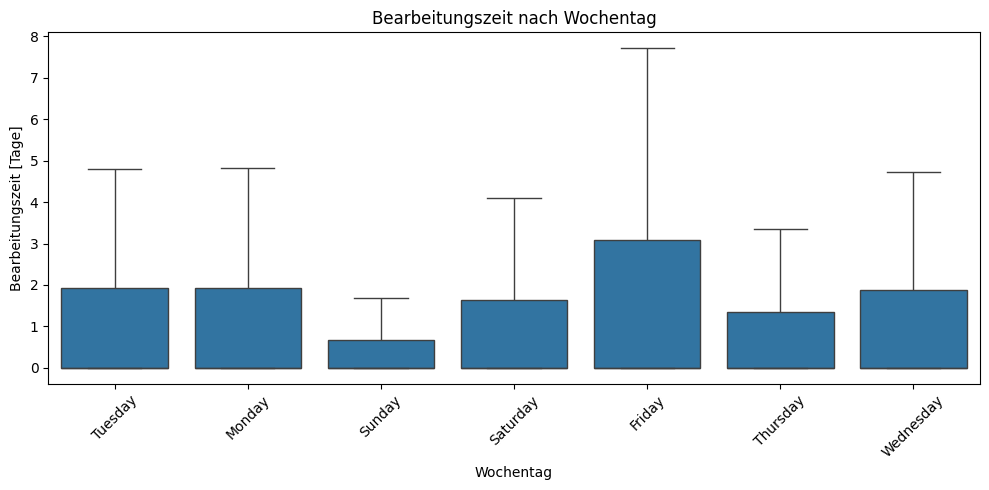

In [185]:
# Bearbeitungszeit nach Wochentag
erledigt["weekday"] = erledigt["CREATED_DATE"].dt.day_name()

plt.figure(figsize=(10,5))
sns.boxplot(x="weekday", y="response_time", data=erledigt, showfliers=False)
plt.xticks(rotation=45)
plt.title("Bearbeitungszeit nach Wochentag")
plt.xlabel("Wochentag")
plt.ylabel("Bearbeitungszeit [Tage]")
plt.tight_layout()
plt.show()

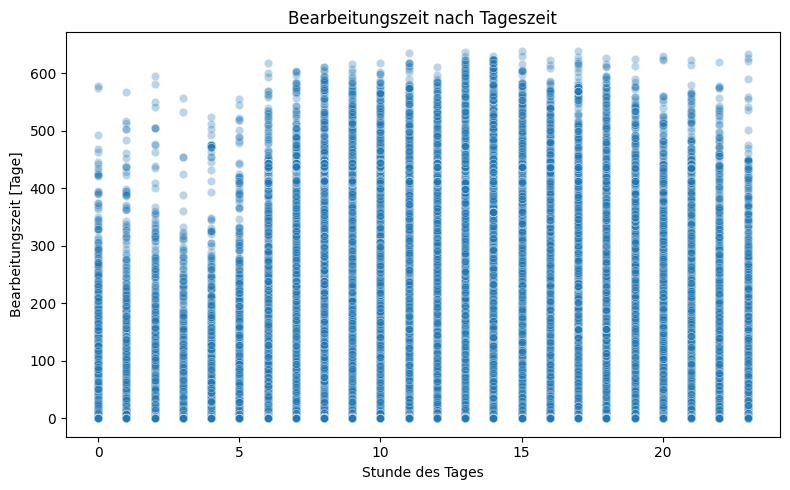

In [186]:
# Bearbeitungszeit nach Tageszeit mit einem Scatterplot
erledigt["hour"] = erledigt["CREATED_DATE"].dt.hour

plt.figure(figsize=(8,5))
sns.scatterplot(x="hour", y="response_time", data=erledigt, alpha=0.3)
plt.title("Bearbeitungszeit nach Tageszeit")
plt.xlabel("Stunde des Tages")
plt.ylabel("Bearbeitungszeit [Tage]")
plt.tight_layout()
plt.show()

In [187]:
# Durchschnittliche Bearbeitungszeit pro Wochentag
avg_by_weekday = (
    erledigt.groupby("weekday")["response_time"]
    .median()  # Median wegen Schiefe robuster
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)
print("\nMedian der Bearbeitungszeit pro Wochentag:")
print(avg_by_weekday.round(2))


Median der Bearbeitungszeit pro Wochentag:
weekday
Monday       0.0
Tuesday      0.0
Wednesday    0.0
Thursday     0.0
Friday       0.0
Saturday     0.0
Sunday       0.0
Name: response_time, dtype: float64


Intepretation
Der Median = 0.0 sagt aus, dass 50 % aller Requests eine Bearbeitungszeit ≤ 0 Tage haben. Die meisten Anfragen wurden dementsprechend innerhalb weniger Stunden nach Erstellung abgeschlossen, also am selben Tag.

Dies wiederspiegelt auch den QQ-Plot von vorhin. Dieser zeigte eine stark rechtsschiefe Verteilung, also viele kleine Werte, aber eben wenige extreme große Werte.

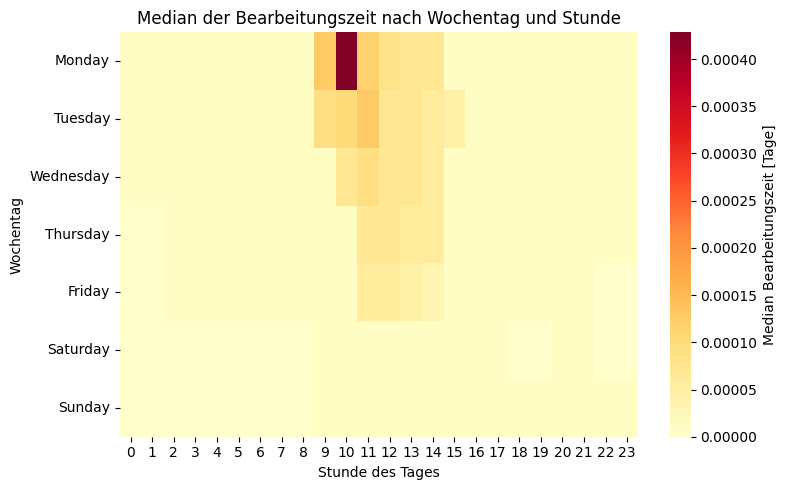

In [188]:
# Durchschnittliche Bearbeitungszeit nach Wochentag und Stunde
pivot = erledigt.pivot_table(index="weekday", columns="hour", values="response_time", aggfunc="median")
pivot = pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.figure(figsize=(8,5))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={"label": "Median Bearbeitungszeit [Tage]"})
plt.title("Median der Bearbeitungszeit nach Wochentag und Stunde")
plt.xlabel("Stunde des Tages")
plt.ylabel("Wochentag")
plt.tight_layout()
plt.show()


Vergleich der Bearbeitungszeit nach Service-Type (SR_TYPE)

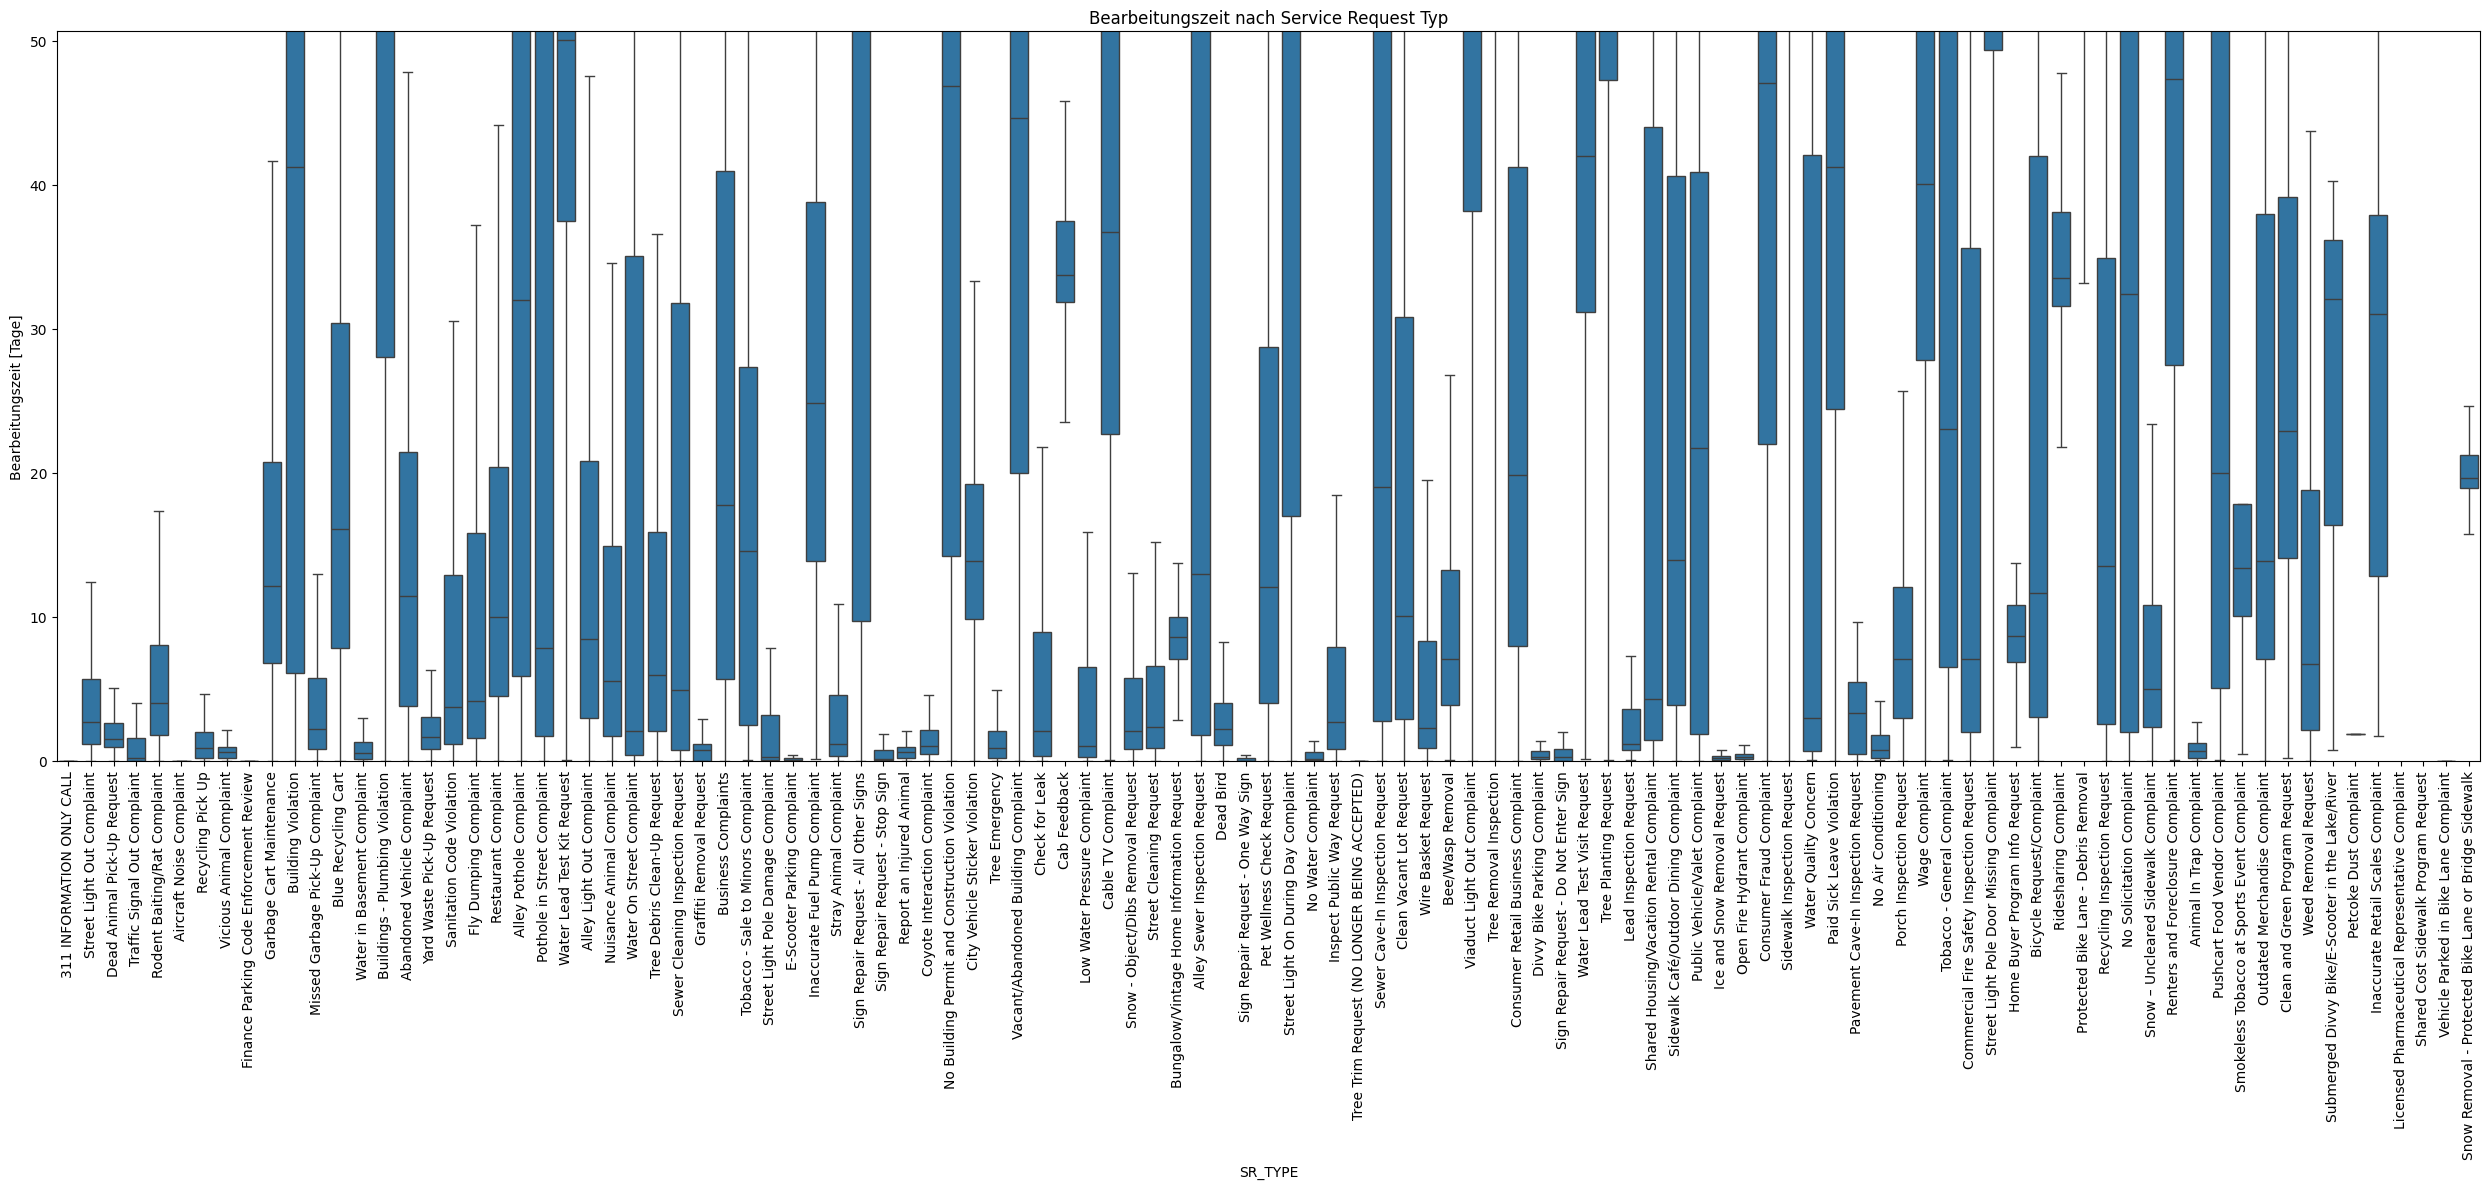

In [189]:
plt.figure(figsize=(25,12))
sns.boxplot(x="SR_TYPE", y="response_time", data=erledigt, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel("Bearbeitungszeit [Tage]")
plt.title("Bearbeitungszeit nach Service Request Typ")
plt.ylim(0, erledigt["response_time"].quantile(0.95)) # um extreme Ausreißer erstmals nicht berücksichtigen 
plt.tight_layout()
plt.show()

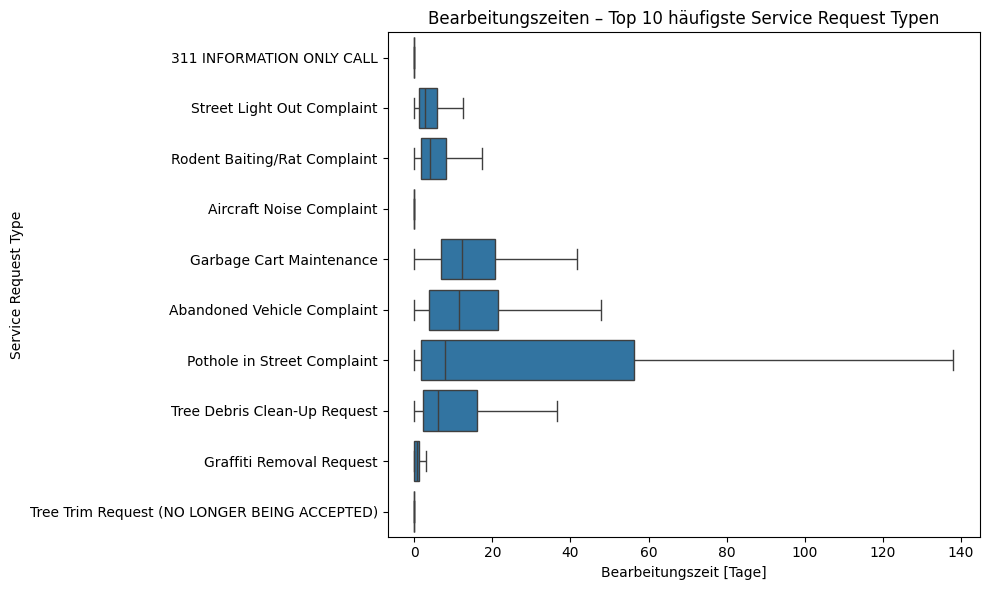

In [190]:
# Top 10 häufigste SR-Typen
top_types = erledigt["SR_TYPE"].value_counts().head(10).index
subset_top = erledigt[erledigt["SR_TYPE"].isin(top_types)]

plt.figure(figsize=(10,6))
sns.boxplot(data=subset_top, y="SR_TYPE", x="response_time", showfliers=False)
plt.title("Bearbeitungszeiten – Top 10 häufigste Service Request Typen")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Durchschnittliche Bearbeitungszeit pro SR_TYPE

In [191]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

avg_time_by_type = (
    erledigt.groupby("SR_TYPE")
    .agg(
        mean_days=("response_time", "mean"),       # klassischer Mittelwert
        median_days=("response_time", "median"),   # Median
        iqr_days=("response_time", iqr),           # IQR
        mean_hours=("response_time_hours", "mean"),
        median_hours=("response_time_hours", "median")
    )
    .round(2)
    .sort_values(by="median_days", ascending=False)
    .reset_index()
)

# Top 10 und Bottom 10 nach Median
top10 = avg_time_by_type.head(10)
bottom10 = avg_time_by_type.tail(10)

print("\nTop 10 mit längster Bearbeitungszeit (nach Median):\n")
print(top10[["SR_TYPE", "median_days", "iqr_days"]].to_string(index=False))

print("\nBottom 10 mit kürzester Bearbeitungszeit (nach Median):\n")
print(bottom10[["SR_TYPE", "median_days", "iqr_days"]].to_string(index=False))



Top 10 mit längster Bearbeitungszeit (nach Median):

                                 SR_TYPE  median_days  iqr_days
    Shared Cost Sidewalk Program Request       435.90     24.91
    Protected Bike Lane - Debris Removal       343.44    175.05
             Sidewalk Inspection Request       281.13    186.40
                 Tree Removal Inspection       162.10    139.75
                   Tree Planting Request       149.98    262.74
Street Light Pole Door Missing Complaint       147.61    314.62
   Sign Repair Request - All Other Signs       104.67    260.06
             Viaduct Light Out Complaint        99.29    173.19
          Buildings - Plumbing Violation        83.94    137.79
    Street Light On During Day Complaint        72.88    169.09

Bottom 10 mit kürzester Bearbeitungszeit (nach Median):

                                     SR_TYPE  median_days  iqr_days
                Ice and Snow Removal Request         0.16      0.28
                          No Water Complaint    

Interpretation
Bearbeitungszeit stark abhängig vom Request-Typ.
Die meisten Service Requests werden extrem schnell erledigt (Median ca. 0 Tage).
Nur einige wenige Typen insbesondere Bau-, Inspektions- und Baumprojekte ziehen den Gesamtdurchschnitt nach oben und zeigen große Streuung.

Visuelle Analyse zum Zusammenhang zwischen Request-Typ und Bearbeitungszeit

Balkendiagramme (Top/Bottom 10 nach Median)

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\2534669083.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


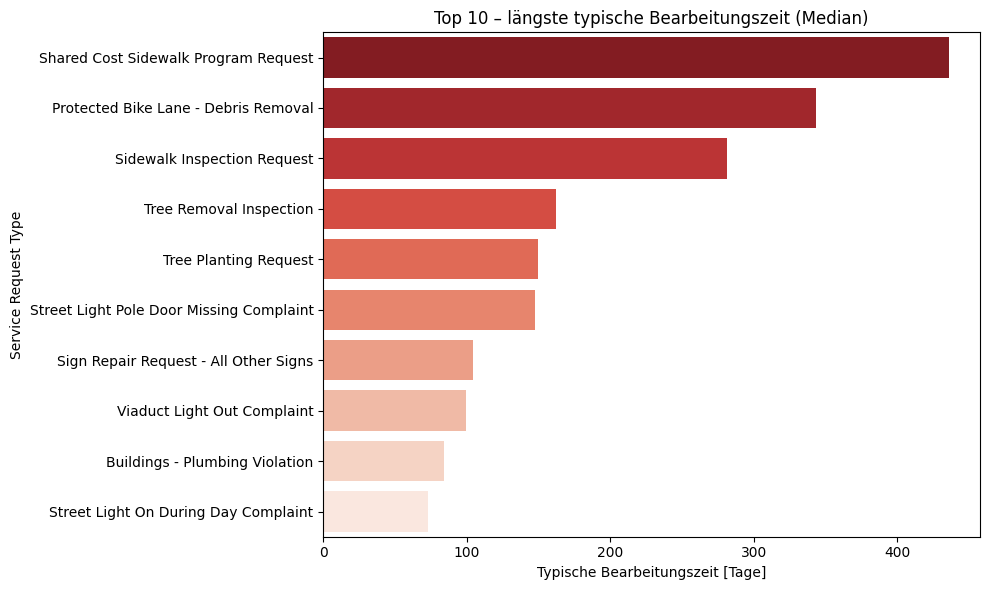

In [192]:
# Top 10
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10.sort_values(by="median_days", ascending=False),
    x="median_days",
    y="SR_TYPE",
    palette="Reds_r",
    errorbar=None  # keine Konfidenzintervalle des Mittelwerts anzeigen
)
plt.title("Top 10 – längste typische Bearbeitungszeit (Median)")
plt.xlabel("Typische Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


Interpretation
Das sind komplexe Projekte mit mehrstufigen und administrativen Abläufen, welche entsprechend mehr Zeit beantspruchen zur Finanzierung, Planung und Bauverwaltung. Diese Service-Typen betreffen langfristige oder genehmigungspflichtige Arbeiten (Bau, Infrastruktur, Umwelt).

Der hohe Median deutet klar auf Prozesse mit Wartezeiten, Planung oder Abhängigkeiten hin.
Dies weist auf mehrstufige Abläufe, Abhängigkeiten von Jahreszeiten oder externen Auftragnehmern.

In Kombination mit den hohen IQR-Werten (aus deiner Tabelle zuvor) zeigt sich, dass diese Prozesse nicht nur lang, sondern auch ungleichmäßig ablaufen, also dass große Unterschiede zwischen einzelnen Fällen bestehen.

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\3890670959.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


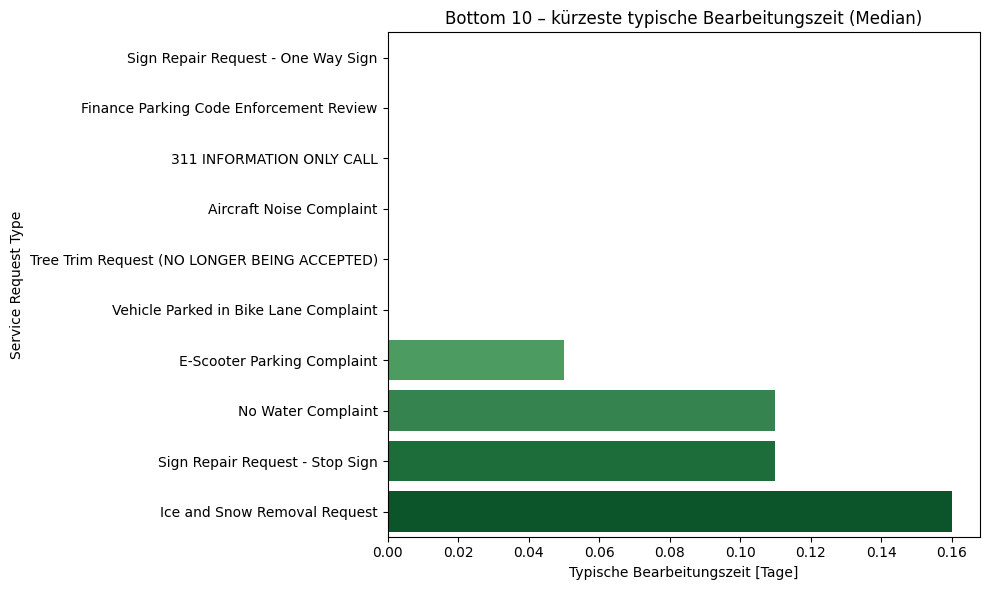

In [193]:
# Bottom 10
plt.figure(figsize=(10,6))
sns.barplot(
    data=bottom10.sort_values(by="median_days", ascending=True),
    x="median_days",
    y="SR_TYPE",
    palette="Greens",
    errorbar=None
)
plt.title("Bottom 10 – kürzeste typische Bearbeitungszeit (Median)")
plt.xlabel("Typische Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Interpretation
Die kürzesten Bearbeitungszeiten finden sich bei standardisierten Routine- und Sicherheitsmeldungen, die sofort bearbeitet oder automatisch abgeschlossen werden.
Diese Prozesse sind effizient, konsistent und zeigen kaum Schwankungen, was ein guter Indikator für automatisierte Abläufe ist.

Boxplots Verteilung der Top/Bottom 10 nach Median

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\2012741625.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


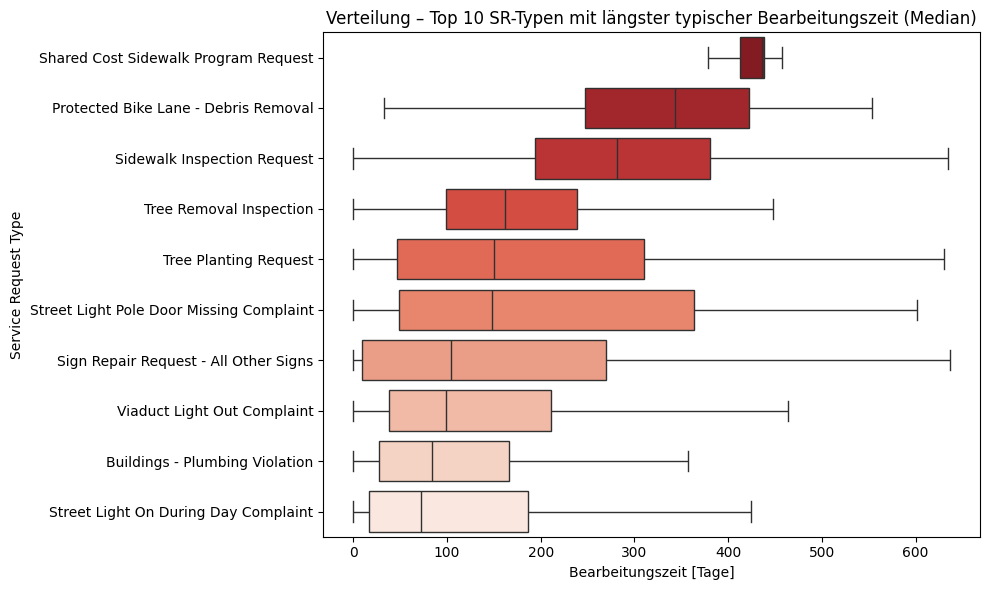

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\2012741625.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


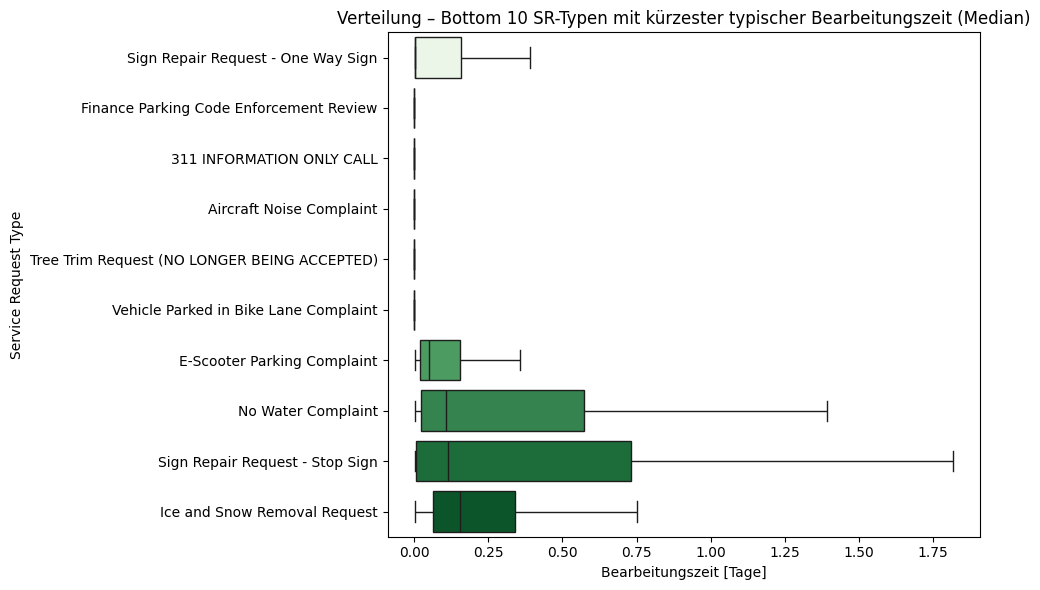

In [197]:
# Top 10 
top_types_sorted = top10.sort_values(by="median_days", ascending=False)["SR_TYPE"]
subset_top10 = erledigt[erledigt["SR_TYPE"].isin(top_types_sorted)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=subset_top10,
    y="SR_TYPE",
    x="response_time",
    order=top_types_sorted,     # Sortierung nach Median
    showfliers=False,
    palette="Reds_r"
)
plt.title("Verteilung – Top 10 SR-Typen mit längster typischer Bearbeitungszeit (Median)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

# Bottom 10
bottom_types_sorted = bottom10.sort_values(by="median_days", ascending=True)["SR_TYPE"]
subset_bottom10 = erledigt[erledigt["SR_TYPE"].isin(bottom_types_sorted)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=subset_bottom10,
    y="SR_TYPE",
    x="response_time",
    order=bottom_types_sorted,  # Sortierung nach Median
    showfliers=False,
    palette="Greens"
)
plt.title("Verteilung – Bottom 10 SR-Typen mit kürzester typischer Bearbeitungszeit (Median)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\4176317909.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\4176317909.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


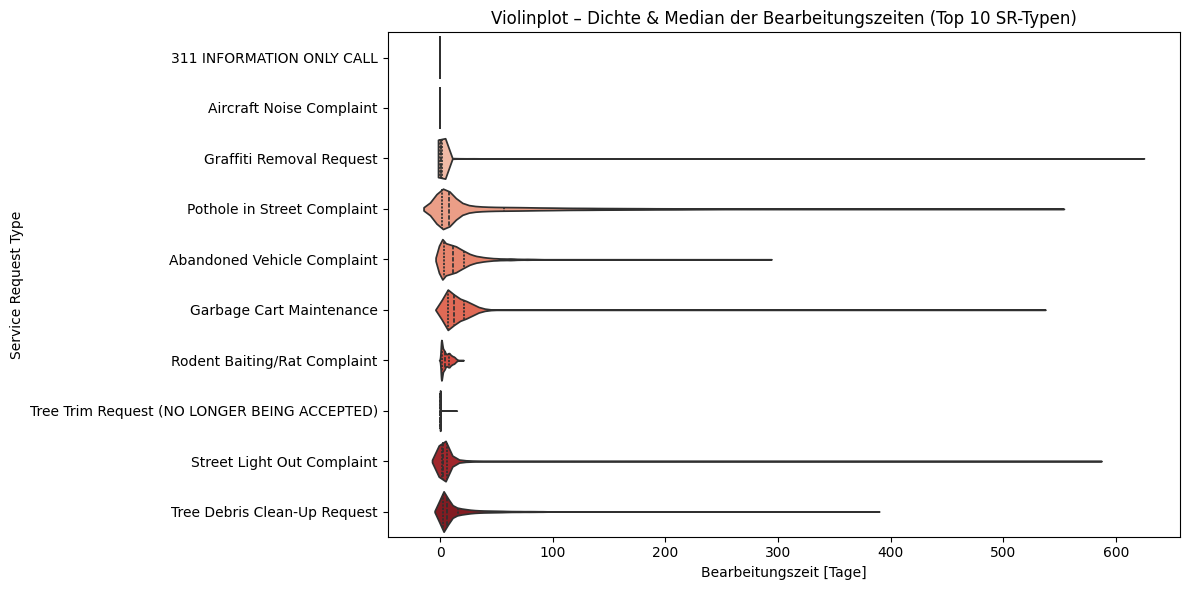

In [ ]:
# Violinplot
plt.figure(figsize=(12,6))
sns.violinplot(
    data=erledigt[erledigt["SR_TYPE"].isin(top_types)],
    y="SR_TYPE",
    x="response_time_days",
    order=top_types,
    scale="width",
    inner="quartile",
    palette="Reds"
)
plt.title("Violinplot – Dichte und Median der Bearbeitungszeiten (Top 10 SR-Typen)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


Wahrscheinlichkeit und Verteilungen

In [ ]:
# Gesamte Wahrscheinlichkeit über alle Anfragen, dass die Bearbeitungszeit folgende Wahrscheinlichkeiten berträgt:

p_over_1 = (erledigt["response_time"] > 1).mean() # mean() um die True Werte zu bekommen
p_under_1 = (erledigt["response_time"] < 1).mean()
p_over_10 = (erledigt["response_time"] > 10).mean()
p_over_30 = (erledigt["response_time"] > 30).mean()

print(f"P(X > 1 Tag)   = {p_over_1:.2%}")
print(f"P(X < 1 Tag)   = {p_under_1:.2%}")
print(f"P(X > 10 Tage) = {p_over_10:.2%}")
print(f"P(X > 30 Tage) = {p_over_30:.2%}")


P(X > 1 Tag)   = 28.50%
P(X < 1 Tag)   = 71.50%
P(X > 10 Tage) = 13.56%
P(X > 30 Tage) = 7.21%


Wahrscheinlichkeit P(X > 10 Tage) je Service Request Type zur Bearbeitung

In [ ]:
# Wahrscheinlichkeit je SR_TYPE
prob_over10_by_type = (
    erledigt.groupby("SR_TYPE")["response_time"]
    .apply(lambda x: (x > 10).mean())
    .sort_values(ascending=False)
)

# Tabellenansicht
print("\nTop 10 SR-Typen mit höchster Wahrscheinlichkeit > 10 Tage:\n")
print(prob_over10_by_type.head(10).round(3))

print("\nBottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit > 10 Tage:\n")
print(prob_over10_by_type.tail(10).round(3))


Top 10 SR-Typen mit höchster Wahrscheinlichkeit > 10 Tage:

SR_TYPE
Licensed Pharmaceutical Representative Complaint         1.000
Shared Cost Sidewalk Program Request                     1.000
Protected Bike Lane - Debris Removal                     1.000
Snow Removal - Protected Bike Lane or Bridge Sidewalk    1.000
Water Lead Test Kit Request                              0.994
Sidewalk Inspection Request                              0.993
Tree Removal Inspection                                  0.984
Water Lead Test Visit Request                            0.978
Cab Feedback                                             0.972
Tree Planting Request                                    0.962
Name: response_time, dtype: float64

Bottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit > 10 Tage:

SR_TYPE
Vicious Animal Complaint                        0.0
Finance Parking Code Enforcement Review         0.0
Dead Animal Pick-Up Request                     0.0
Tree Trim Request (NO LONGER BEING

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\67737570.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


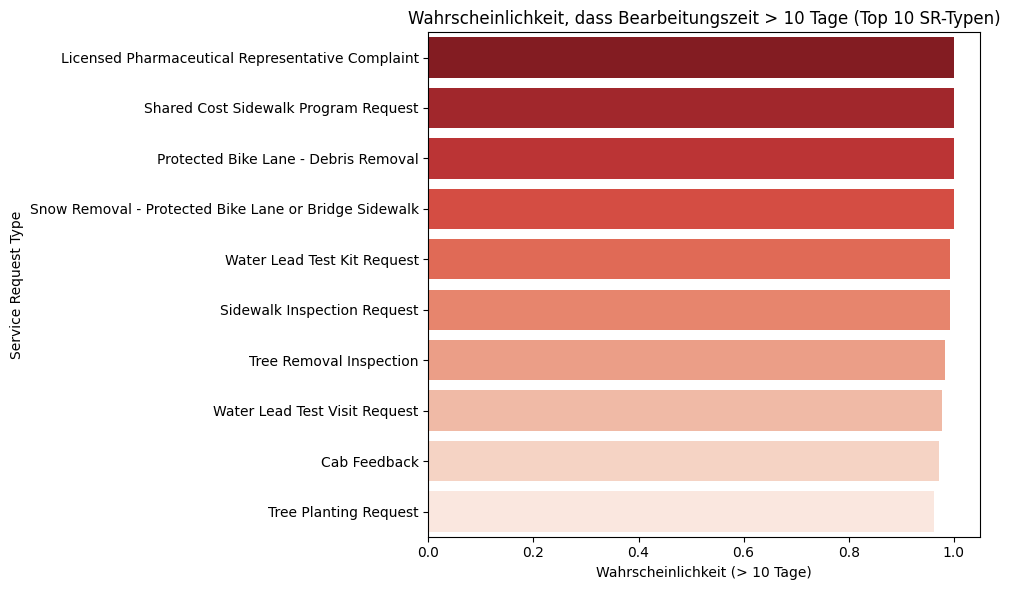

In [ ]:
# Visualisierung: Top 10
top10_prob = prob_over10_by_type.head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_prob,
    x="response_time",
    y="SR_TYPE",
    palette="Reds_r"
)
plt.title("Wahrscheinlichkeit, dass Bearbeitungszeit > 10 Tage (Top 10 SR-Typen)")
plt.xlabel("Wahrscheinlichkeit (> 10 Tage)")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Wahrscheinlichkeit P(X < 1 Tag) je Service Request Type zur Bearbeitung

In [ ]:
# Wahrscheinlichkeit je SR_TYPE
prob_under1_by_type = (
    erledigt.groupby("SR_TYPE")["response_time"]
    .apply(lambda x: (x > 10).mean())
    .sort_values(ascending=False)
)

# Tabellenansicht
print("\nTop 10 SR-Typen mit höchster Wahrscheinlichkeit < 1 Tag:\n")
print(prob_under1_by_type.head(10).round(3))

print("\nBottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit <1 Tag:\n")
print(prob_under1_by_type.tail(10).round(3))


Top 10 SR-Typen mit höchster Wahrscheinlichkeit < 1 Tag:

SR_TYPE
Licensed Pharmaceutical Representative Complaint         1.000
Shared Cost Sidewalk Program Request                     1.000
Protected Bike Lane - Debris Removal                     1.000
Snow Removal - Protected Bike Lane or Bridge Sidewalk    1.000
Water Lead Test Kit Request                              0.994
Sidewalk Inspection Request                              0.993
Tree Removal Inspection                                  0.984
Water Lead Test Visit Request                            0.978
Cab Feedback                                             0.972
Tree Planting Request                                    0.962
Name: response_time, dtype: float64

Bottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit <1 Tag:

SR_TYPE
Vicious Animal Complaint                        0.0
Finance Parking Code Enforcement Review         0.0
Dead Animal Pick-Up Request                     0.0
Tree Trim Request (NO LONGER BEING ACCE

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_11604\3907378303.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


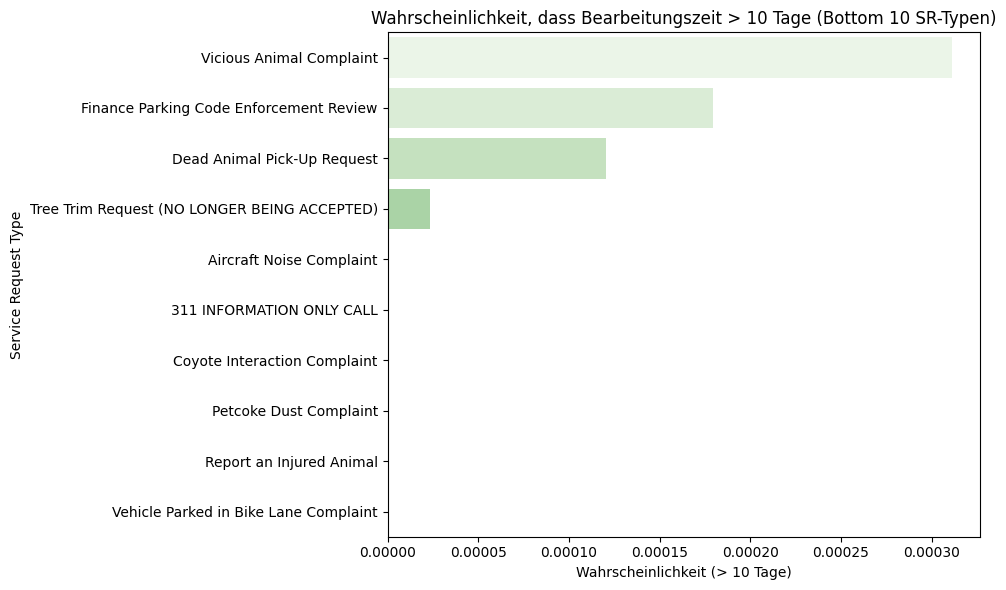

In [ ]:
# Visualisierung: Bottom 10
bottom10_prob = prob_under1_by_type.tail(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=bottom10_prob,
    x="response_time",
    y="SR_TYPE",
    palette="Greens"
)
plt.title("Wahrscheinlichkeit, dass Bearbeitungszeit > 10 Tage (Bottom 10 SR-Typen)")
plt.xlabel("Wahrscheinlichkeit (> 10 Tage)")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Schätzung und Konfidenzintervalle

In [ ]:
# 95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit
x = erledigt["response_time"].dropna()

mean = np.mean(x)
se = stats.sem(x)  # Standardfehler des Mittelwerts
ci = stats.t.interval(confidence=0.95, df=len(x)-1, loc=mean, scale=se)

print("95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit:")
print(f"Schätzer (Mittelwert): {mean:.2f} Tage")
print(f"95%-Konfidenzintervall: [{ci[0]:.2f}, {ci[1]:.2f}] Tage")

95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit:
Schätzer (Mittelwert): 10.52 Tage
95%-Konfidenzintervall: [10.46, 10.58] Tage


Interpretation
Der Mittelwert ist stark durch Ausreißer beeinflusst.
Es zeigt mit 95 % Sicherheit befindet sich der wahre Mittelwert der Bearbeitungszeit in diesem Intervall von [10.46, 10.58] Tagen.